In [1]:
# Force set MLflow tracking URI from environment
import os
os.environ["MLFLOW_TRACKING_URI"] = "http://mlflow-proxy"
print(f"✅ Set MLFLOW_TRACKING_URI to: {os.environ['MLFLOW_TRACKING_URI']}")

✅ Set MLFLOW_TRACKING_URI to: http://mlflow-proxy


# Customer Churn Prediction - Complete MLOps Workflow

**Simulates:** Azure ML experiment tracking and model management  
**Tech Stack:** MLflow, Scikit-learn, Pandas

This notebook demonstrates a complete ML lifecycle:
1. Data preparation
2. Experiment tracking
3. Model training and evaluation
4. Model registry
5. Model deployment

In [2]:
# Install required packages with compatible versions
%pip install -q --upgrade pip
%pip uninstall -y -q streamlit pyopenssl cryptography || true
# Install MLflow first which will pull compatible dependencies
%pip install -q "mlflow==3.6.0"
# Then install remaining packages
%pip install -q scikit-learn pandas numpy matplotlib seaborn
print("✅ Package installation complete")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ Package installation complete


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import mlflow
import mlflow.sklearn
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")
print(f"MLflow version: {mlflow.__version__}")

✅ Libraries imported successfully
MLflow version: 3.6.0


## 1. Setup MLflow Tracking

In [4]:
# Configure MLflow (works inside Docker or on host)
import socket, os
import mlflow

# Check if MLFLOW_TRACKING_URI is already set by the container environment
_env_uri = os.environ.get("MLFLOW_TRACKING_URI")

if _env_uri:
    # Use the environment variable (set by docker-compose for Jupyter container)
    MLFLOW_TRACKING_URI = _env_uri
    print(f"🐳 Using MLflow URI from environment: {MLFLOW_TRACKING_URI}")
else:
    # Fallback: auto-detect for host environment
    def _host_resolves(name: str) -> bool:
        try:
            socket.gethostbyname(name)
            return True
        except Exception:
            return False
    
    _default_host = "mlflow" if _host_resolves("mlflow") else "localhost"
    MLFLOW_HOST = os.environ.get("MLFLOW_HOST_OVERRIDE", _default_host)
    MLFLOW_TRACKING_URI = f"http://{MLFLOW_HOST}:5000"
    print(f"🖥️  Auto-detected MLflow URI: {MLFLOW_TRACKING_URI}")

EXPERIMENT_NAME = "customer-churn-prediction"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"📊 MLflow Tracking URI: {MLFLOW_TRACKING_URI}")
print(f"🧪 Experiment: {EXPERIMENT_NAME}")
print(f"🔗 MLflow UI: http://localhost:5000")

🐳 Using MLflow URI from environment: http://mlflow-proxy
📊 MLflow Tracking URI: http://mlflow-proxy
🧪 Experiment: customer-churn-prediction
🔗 MLflow UI: http://localhost:5000


## 2. Generate Sample Dataset

For this demo, we'll create a synthetic customer churn dataset.
In production, you'd load real data from your data warehouse.

In [5]:
def generate_churn_dataset(n_samples=5000, random_state=42):
    """Generate synthetic customer churn dataset"""
    np.random.seed(random_state)
    
    # Customer demographics
    customer_ids = np.arange(1, n_samples + 1)
    tenure = np.random.randint(1, 72, n_samples)  # Months
    age = np.random.randint(18, 80, n_samples)
    
    # Contract details
    contract_types = np.random.choice(
        ['Month-to-month', 'One year', 'Two year'],
        n_samples,
        p=[0.5, 0.3, 0.2]
    )
    
    # Services
    internet_service = np.random.choice(
        ['DSL', 'Fiber optic', 'No'],
        n_samples,
        p=[0.3, 0.5, 0.2]
    )
    
    online_security = np.random.choice(['Yes', 'No'], n_samples, p=[0.3, 0.7])
    tech_support = np.random.choice(['Yes', 'No'], n_samples, p=[0.3, 0.7])
    streaming_tv = np.random.choice(['Yes', 'No'], n_samples, p=[0.4, 0.6])
    
    # Billing
    monthly_charges = np.random.uniform(20, 120, n_samples)
    total_charges = tenure * monthly_charges + np.random.normal(0, 50, n_samples)
    total_charges = np.maximum(total_charges, 0)  # No negative charges
    
    payment_method = np.random.choice(
        ['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
        n_samples,
        p=[0.4, 0.2, 0.2, 0.2]
    )
    
    # Generate churn (target variable)
    # Higher churn probability for:
    # - Month-to-month contracts
    # - High monthly charges
    # - Low tenure
    # - Electronic check payment
    
    churn_prob = np.zeros(n_samples)
    
    # Contract type influence
    churn_prob += np.where(contract_types == 'Month-to-month', 0.3, 0)
    churn_prob += np.where(contract_types == 'One year', 0.1, 0)
    
    # Tenure influence (inverse)
    churn_prob += 0.3 * (1 - tenure / 72)
    
    # Monthly charges influence
    churn_prob += 0.2 * (monthly_charges / 120)
    
    # Payment method influence
    churn_prob += np.where(payment_method == 'Electronic check', 0.15, 0)
    
    # Service quality influence
    churn_prob -= np.where(online_security == 'Yes', 0.1, 0)
    churn_prob -= np.where(tech_support == 'Yes', 0.1, 0)
    
    # Add some randomness
    churn_prob += np.random.normal(0, 0.1, n_samples)
    churn_prob = np.clip(churn_prob, 0, 1)
    
    # Generate actual churn
    churn = (np.random.random(n_samples) < churn_prob).astype(int)
    
    # Create DataFrame
    df = pd.DataFrame({
        'customer_id': customer_ids,
        'tenure': tenure,
        'age': age,
        'contract_type': contract_types,
        'internet_service': internet_service,
        'online_security': online_security,
        'tech_support': tech_support,
        'streaming_tv': streaming_tv,
        'monthly_charges': monthly_charges,
        'total_charges': total_charges,
        'payment_method': payment_method,
        'churn': churn
    })
    
    return df

# Generate dataset
print("🔄 Generating dataset...")
df = generate_churn_dataset(n_samples=5000)
print(f"✅ Generated {len(df)} customer records")
print(f"📊 Churn rate: {df['churn'].mean():.2%}")

🔄 Generating dataset...
✅ Generated 5000 customer records
📊 Churn rate: 43.46%


## 3. Exploratory Data Analysis

In [6]:
# Display basic info
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(df.head())
print("\n" + "=" * 60)
print("DATASET INFO")
print("=" * 60)
print(df.info())
print("\n" + "=" * 60)
print("DESCRIPTIVE STATISTICS")
print("=" * 60)
print(df.describe())

DATASET OVERVIEW
   customer_id  tenure  age   contract_type internet_service online_security  \
0            1      52   62        Two year              DSL             Yes   
1            2      15   63  Month-to-month      Fiber optic              No   
2            3      61   25        One year      Fiber optic             Yes   
3            4      21   61        One year               No             Yes   
4            5      24   72        One year      Fiber optic             Yes   

  tech_support streaming_tv  monthly_charges  total_charges    payment_method  \
0          Yes           No        30.113200    1488.343419     Bank transfer   
1           No           No       116.347212    1759.552558  Electronic check   
2           No           No       104.630418    6358.873683     Bank transfer   
3           No          Yes        58.877261    1241.803166  Electronic check   
4           No          Yes        92.841759    2219.926123  Electronic check   

   churn  
0   

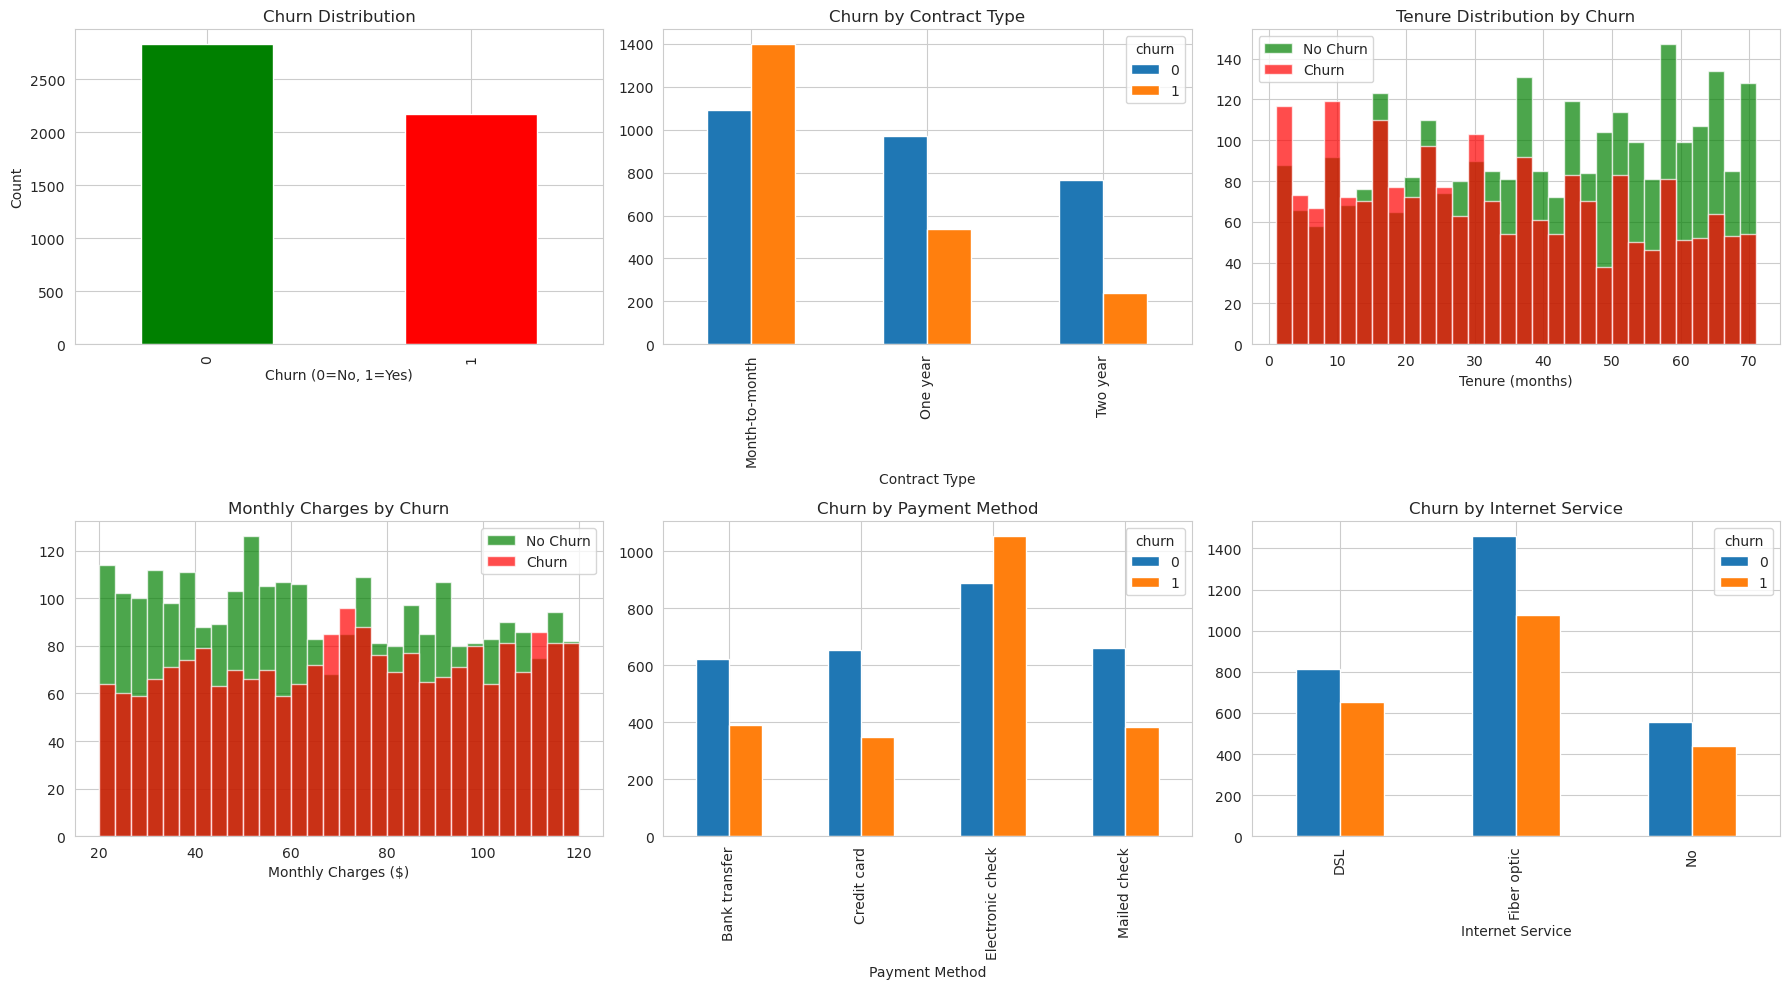

✅ EDA visualizations saved


In [7]:
# Visualize churn distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Churn distribution
df['churn'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['green', 'red'])
axes[0, 0].set_title('Churn Distribution')
axes[0, 0].set_xlabel('Churn (0=No, 1=Yes)')
axes[0, 0].set_ylabel('Count')

# Churn by contract type
pd.crosstab(df['contract_type'], df['churn']).plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Churn by Contract Type')
axes[0, 1].set_xlabel('Contract Type')

# Tenure distribution
df[df['churn']==0]['tenure'].hist(bins=30, ax=axes[0, 2], alpha=0.7, label='No Churn', color='green')
df[df['churn']==1]['tenure'].hist(bins=30, ax=axes[0, 2], alpha=0.7, label='Churn', color='red')
axes[0, 2].set_title('Tenure Distribution by Churn')
axes[0, 2].set_xlabel('Tenure (months)')
axes[0, 2].legend()

# Monthly charges
df[df['churn']==0]['monthly_charges'].hist(bins=30, ax=axes[1, 0], alpha=0.7, label='No Churn', color='green')
df[df['churn']==1]['monthly_charges'].hist(bins=30, ax=axes[1, 0], alpha=0.7, label='Churn', color='red')
axes[1, 0].set_title('Monthly Charges by Churn')
axes[1, 0].set_xlabel('Monthly Charges ($)')
axes[1, 0].legend()

# Churn by payment method
pd.crosstab(df['payment_method'], df['churn']).plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Churn by Payment Method')
axes[1, 1].set_xlabel('Payment Method')

# Churn by internet service
pd.crosstab(df['internet_service'], df['churn']).plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title('Churn by Internet Service')
axes[1, 2].set_xlabel('Internet Service')

plt.tight_layout()
plt.savefig('eda_churn_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ EDA visualizations saved")

## 4. Data Preprocessing

In [8]:
def preprocess_data(df):
    """Preprocess the dataset for modeling"""
    # Create a copy
    data = df.copy()
    
    # Drop customer_id (not a feature)
    data = data.drop('customer_id', axis=1)
    
    # Separate features and target
    X = data.drop('churn', axis=1)
    y = data['churn']
    
    # Encode categorical variables
    categorical_cols = X.select_dtypes(include=['object']).columns
    
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    
    # Scale numerical features
    scaler = StandardScaler()
    numerical_cols = ['tenure', 'age', 'monthly_charges', 'total_charges']
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
    return X, y, label_encoders, scaler

# Preprocess data
print("🔄 Preprocessing data...")
X, y, label_encoders, scaler = preprocess_data(df)
print(f"✅ Features shape: {X.shape}")
print(f"✅ Target shape: {y.shape}")
print(f"✅ Feature columns: {list(X.columns)}")

🔄 Preprocessing data...
✅ Features shape: (5000, 10)
✅ Target shape: (5000,)
✅ Feature columns: ['tenure', 'age', 'contract_type', 'internet_service', 'online_security', 'tech_support', 'streaming_tv', 'monthly_charges', 'total_charges', 'payment_method']


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Training set: {X_train.shape[0]} samples")
print(f"📊 Test set: {X_test.shape[0]} samples")
print(f"📊 Training churn rate: {y_train.mean():.2%}")
print(f"📊 Test churn rate: {y_test.mean():.2%}")

📊 Training set: 4000 samples
📊 Test set: 1000 samples
📊 Training churn rate: 43.45%
📊 Test churn rate: 43.50%


## 5. Model Training with MLflow Tracking

We'll train multiple models and track experiments in MLflow.

In [10]:
def train_and_log_model(model, model_name, X_train, y_train, X_test, y_test, params=None):
    """Train model and log metrics to MLflow"""
    
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        if params:
            mlflow.log_params(params)
        
        # Train model
        print(f"🔄 Training {model_name}...")
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Get probabilities if available
        if hasattr(model, 'predict_proba'):
            y_pred_proba_train = model.predict_proba(X_train)[:, 1]
            y_pred_proba_test = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba_train = y_pred_train
            y_pred_proba_test = y_pred_test
        
        # Calculate metrics
        metrics = {
            'train_accuracy': accuracy_score(y_train, y_pred_train),
            'test_accuracy': accuracy_score(y_test, y_pred_test),
            'train_precision': precision_score(y_train, y_pred_train),
            'test_precision': precision_score(y_test, y_pred_test),
            'train_recall': recall_score(y_train, y_pred_train),
            'test_recall': recall_score(y_test, y_pred_test),
            'train_f1': f1_score(y_train, y_pred_train),
            'test_f1': f1_score(y_test, y_pred_test),
            'train_auc': roc_auc_score(y_train, y_pred_proba_train),
            'test_auc': roc_auc_score(y_test, y_pred_proba_test)
        }
        
        # Log metrics
        mlflow.log_metrics(metrics)
        
        # Log model
        mlflow.sklearn.log_model(model, "model")
        
        # Create and log confusion matrix plot
        fig, ax = plt.subplots(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred_test)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix - {model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        plt.savefig(f'confusion_matrix_{model_name}.png')
        mlflow.log_artifact(f'confusion_matrix_{model_name}.png')
        plt.close()
        
        # Log feature importance if available
        if hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': X_train.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.barplot(data=importance_df.head(10), x='importance', y='feature', ax=ax)
            ax.set_title(f'Top 10 Feature Importances - {model_name}')
            plt.tight_layout()
            plt.savefig(f'feature_importance_{model_name}.png')
            mlflow.log_artifact(f'feature_importance_{model_name}.png')
            plt.close()
        
        print(f"✅ {model_name} trained successfully")
        print(f"   Test Accuracy: {metrics['test_accuracy']:.4f}")
        print(f"   Test F1: {metrics['test_f1']:.4f}")
        print(f"   Test AUC: {metrics['test_auc']:.4f}")
        
        return model, metrics

In [11]:
# Train multiple models
print("=" * 60)
print("TRAINING MODELS")
print("=" * 60)

models_results = {}

# 1. Logistic Regression
lr_params = {'C': 1.0, 'max_iter': 1000, 'random_state': 42}
lr_model, lr_metrics = train_and_log_model(
    LogisticRegression(**lr_params),
    "Logistic_Regression",
    X_train, y_train, X_test, y_test,
    lr_params
)
models_results['Logistic Regression'] = lr_metrics

print()

# 2. Random Forest
rf_params = {'n_estimators': 100, 'max_depth': 10, 'random_state': 42}
rf_model, rf_metrics = train_and_log_model(
    RandomForestClassifier(**rf_params),
    "Random_Forest",
    X_train, y_train, X_test, y_test,
    rf_params
)
models_results['Random Forest'] = rf_metrics

print()

# 3. Gradient Boosting
gb_params = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 42}
gb_model, gb_metrics = train_and_log_model(
    GradientBoostingClassifier(**gb_params),
    "Gradient_Boosting",
    X_train, y_train, X_test, y_test,
    gb_params
)
models_results['Gradient Boosting'] = gb_metrics

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)

2025/11/16 23:16:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


TRAINING MODELS
🔄 Training Logistic_Regression...


2025/11/16 23:16:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logistic_Regression trained successfully
   Test Accuracy: 0.6380
   Test F1: 0.5617
   Test AUC: 0.6826
🏃 View run Logistic_Regression at: http://mlflow-proxy/#/experiments/1/runs/bb1af1d8bc834c53a57a20fe0e708baa
🧪 View experiment at: http://mlflow-proxy/#/experiments/1

🔄 Training Random_Forest...


2025/11/16 23:16:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 23:16:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Random_Forest trained successfully
   Test Accuracy: 0.6410
   Test F1: 0.5584
   Test AUC: 0.6929
🏃 View run Random_Forest at: http://mlflow-proxy/#/experiments/1/runs/f04cd27a747442c5942c993371792dd1
🧪 View experiment at: http://mlflow-proxy/#/experiments/1

🔄 Training Gradient_Boosting...


2025/11/16 23:16:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/16 23:16:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Gradient_Boosting trained successfully
   Test Accuracy: 0.6460
   Test F1: 0.5693
   Test AUC: 0.6840
🏃 View run Gradient_Boosting at: http://mlflow-proxy/#/experiments/1/runs/a736458daf12472a9a424d1b0bc92253
🧪 View experiment at: http://mlflow-proxy/#/experiments/1

TRAINING COMPLETE


## 6. Model Comparison


MODEL COMPARISON
                     test_accuracy  test_precision  test_recall   test_f1  \
Logistic Regression          0.638        0.593350     0.533333  0.561743   
Random Forest                0.641        0.600529     0.521839  0.558426   
Gradient Boosting            0.646        0.604651     0.537931  0.569343   

                     test_auc  
Logistic Regression  0.682555  
Random Forest        0.692874  
Gradient Boosting    0.684004  


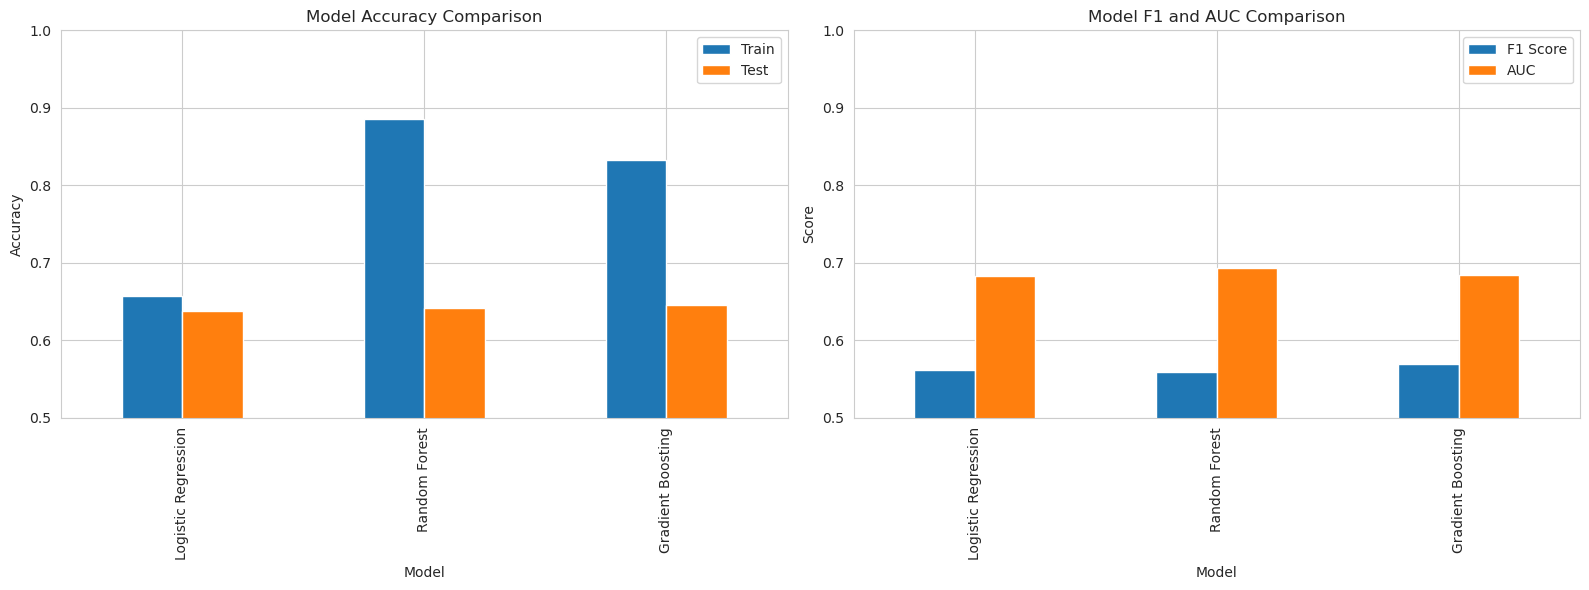


🏆 Best Model: Gradient Boosting
   Test F1 Score: 0.5693
   Test AUC: 0.6840


In [12]:
# Compare models
comparison_df = pd.DataFrame(models_results).T
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
print(comparison_df[['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_auc']])

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
comparison_df[['train_accuracy', 'test_accuracy']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Model')
axes[0].legend(['Train', 'Test'])
axes[0].set_ylim([0.5, 1.0])

# F1 and AUC comparison
comparison_df[['test_f1', 'test_auc']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Model F1 and AUC Comparison')
axes[1].set_ylabel('Score')
axes[1].set_xlabel('Model')
axes[1].legend(['F1 Score', 'AUC'])
axes[1].set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Determine best model
best_model_name = comparison_df['test_f1'].idxmax()
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test F1 Score: {comparison_df.loc[best_model_name, 'test_f1']:.4f}")
print(f"   Test AUC: {comparison_df.loc[best_model_name, 'test_auc']:.4f}")

## 7. Register Best Model

Register the best performing model to MLflow Model Registry for deployment.

In [13]:
# Register best model to Model Registry
MODEL_NAME = "customer_churn_model"

print(f"🔄 Registering best model: {best_model_name}")

# Get the best model's run
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.test_f1 DESC"],
    max_results=1
)

if runs:
    best_run = runs[0]
    best_run_id = best_run.info.run_id
    
    # Register model
    model_uri = f"runs:/{best_run_id}/model"
    
    try:
        # Register model version
        model_version = mlflow.register_model(model_uri, MODEL_NAME)
        
        print(f"✅ Model registered successfully")
        print(f"   Model Name: {MODEL_NAME}")
        print(f"   Version: {model_version.version}")
        print(f"   Run ID: {best_run_id}")
        
        # Transition to Production
        client.transition_model_version_stage(
            name=MODEL_NAME,
            version=model_version.version,
            stage="Production",
            archive_existing_versions=True
        )
        
        print(f"✅ Model transitioned to Production stage")
        
    except Exception as e:
        print(f"⚠️ Model registration info: {str(e)}")
        print(f"   This is expected on first run or if MLflow server is not fully initialized")
        print(f"   Model URI: {model_uri}")
else:
    print("⚠️ No runs found")

Successfully registered model 'customer_churn_model'.
2025/11/16 23:16:11 WARNING mlflow.tracking._model_registry.fluent: Run with id a736458daf12472a9a424d1b0bc92253 has no artifacts at artifact path 'model', registering model based on models:/m-cf151a1ee6f541eeb51f98cfc9fdaa21 instead
2025/11/16 23:16:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: customer_churn_model, version 1


🔄 Registering best model: Gradient Boosting
✅ Model registered successfully
   Model Name: customer_churn_model
   Version: 1
   Run ID: a736458daf12472a9a424d1b0bc92253
✅ Model transitioned to Production stage


Created version '1' of model 'customer_churn_model'.


## 8. Make Predictions with Registered Model

Test loading and using the model from the registry.

In [14]:
# Load model from registry
print("🔄 Loading model from registry...")

try:
    loaded_model = mlflow.pyfunc.load_model(f"models:/{MODEL_NAME}/Production")
    print(f"✅ Model loaded successfully from registry")
    
    # Make sample predictions
    sample_data = X_test.head(10)
    predictions = loaded_model.predict(sample_data)
    
    print("\n" + "=" * 60)
    print("SAMPLE PREDICTIONS")
    print("=" * 60)
    
    results = pd.DataFrame({
        'Actual': y_test.head(10).values,
        'Predicted': predictions,
        'Match': y_test.head(10).values == predictions
    })
    
    print(results)
    print(f"\nAccuracy on sample: {results['Match'].mean():.2%}")
    
except Exception as e:
    print(f"⚠️ Could not load model from registry: {str(e)}")
    print("   This is expected if model registration hasn't completed yet")
    print("   The model can still be accessed directly from the run")

🔄 Loading model from registry...
✅ Model loaded successfully from registry

SAMPLE PREDICTIONS
   Actual  Predicted  Match
0       1          1   True
1       0          1  False
2       1          0  False
3       0          0   True
4       0          0   True
5       0          1  False
6       0          0   True
7       1          0  False
8       0          1  False
9       1          0  False

Accuracy on sample: 40.00%


## 9. Summary and Next Steps

### ✅ What We Accomplished

1. **Generated synthetic customer churn dataset** with realistic patterns
2. **Performed EDA** to understand churn drivers
3. **Preprocessed data** with encoding and scaling
4. **Trained multiple models** (Logistic Regression, Random Forest, Gradient Boosting)
5. **Tracked experiments** in MLflow with comprehensive metrics
6. **Registered best model** to Model Registry
7. **Tested model loading** from registry

### 🚀 Next Steps

1. **Access MLflow UI** at http://localhost:5000 to:
   - Compare experiment runs
   - View metrics and artifacts
   - Manage model versions

2. **Deploy model** using the FastAPI endpoint:
   ```bash
   # The model is automatically deployed via docker-compose
   # Access API docs at: http://localhost:8000/docs
   ```

3. **Make predictions** via REST API:
   ```python
   import requests
   
   response = requests.post(
       "http://localhost:8000/predict",
       json={"features": {...}}
   )
   ```

4. **Set up CI/CD** for automated retraining and deployment

5. **Monitor model performance** in production

### 💡 Interview Tips

When discussing this project:
- Emphasize the **complete ML lifecycle** implementation
- Highlight **experiment tracking** and **reproducibility**
- Discuss **model versioning** and **deployment strategies**
- Explain how this mirrors **Azure ML** workflows
- Show understanding of **MLOps best practices**


In [15]:
print("=" * 60)
print("🎉 MLOps WORKFLOW COMPLETE!")
print("=" * 60)

def _get(name, default):
    return globals().get(name, default)

EXPERIMENT_NAME_SAFE = _get("EXPERIMENT_NAME", "customer-churn-prediction")
BEST_MODEL_NAME_SAFE = _get("best_model_name", "(not computed yet — run training cells)")
MODEL_NAME_SAFE = _get("MODEL_NAME", "customer_churn_model")

print(f"✅ Experiment: {EXPERIMENT_NAME_SAFE}")
print(f"✅ Best Model: {BEST_MODEL_NAME_SAFE}")
print(f"✅ Model Registry: {MODEL_NAME_SAFE}")
print(f"✅ MLflow UI: http://localhost:5000")
print(f"✅ API Docs: http://localhost:8000/docs")
print("=" * 60)

🎉 MLOps WORKFLOW COMPLETE!
✅ Experiment: customer-churn-prediction
✅ Best Model: Gradient Boosting
✅ Model Registry: customer_churn_model
✅ MLflow UI: http://localhost:5000
✅ API Docs: http://localhost:8000/docs
